# Traffic Sign Classifier Project Report

The objective of this code is to make a program that learns how to classify the German Traffic Sign Dataset. 
We are going to use use deep learning and tensorflow to fulfil this task.

In [2]:
#all the imports that we need for the code

%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import time
from datetime import timedelta
import math
import pickle
import PIL.Image
import IPython.display
import matplotlib.gridspec as gridspec
import os
import cv2

# Load data

The dataset is already pickled in 3 files. One for trainig, another one for validation and the last one for testing.
For each set we obtain the features and labels.

In [3]:
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
   train = pickle.load(f)
with open(validation_file, mode='rb') as f:
   valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
   test = pickle.load(f)
        

In [4]:
print("dataset keys", train.keys())

dataset keys dict_keys(['features', 'labels', 'sizes', 'coords'])


In [5]:
#define features and labels of trainig, validation and testing sets.
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
#Inspecting features
print("X_train shape", X_train.shape)
print("X_valid shape", X_valid.shape)
print("X_test  shape", X_test.shape)

X_train shape (34799, 32, 32, 3)
X_valid shape (4410, 32, 32, 3)
X_test  shape (12630, 32, 32, 3)


The images are 32x32 RGB. We have 34799 inputs for training, 4410 for validation and 12630 for testing.
We use the testing set only for the last part, when the model is already built and callibrated.

In [7]:
print("labels values\n", np.unique(y_train))
print("")
print("labels[0:100]\n", y_train[0:100])

labels values
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]

labels[0:100]
 [41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41
 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41 41]


We have 43 unique labels. Between 0 and 42.
Inspecting the labels we see that the inputs are not random. They are ordered by labels. Is important to have the inputs shuffled for training.

In [8]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

img_size = X_train[0].shape[0]

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

In [9]:
### Creating Label Dictionary
import csv

label_dict = None
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None)
    label_dict = {int(rows[0]):rows[1] for rows in reader}

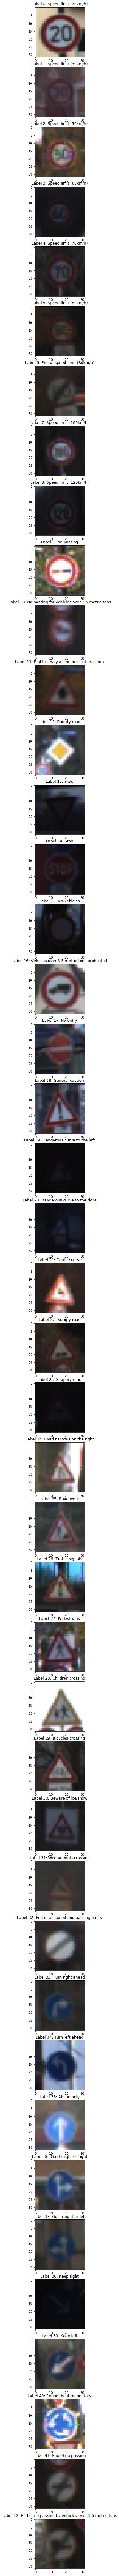

In [16]:
def show_labels_map():
    fig, axes = plt.subplots(nrows=43, ncols=1, figsize=(100, 150))
    for label in np.unique(y_train):
        label_title = label_dict[label]
        index = np.where(y_train==label)[0][0]
        image = X_train[index]
        axes.flat[label].set_title("Label {}: {}".format(label, label_title))
        axes.flat[label].imshow(image)
show_labels_map()

# Visual inspection of data

It's a good idea to inspect visualy the data so we can detect any problems.

In [9]:
def get_images_with_label(features, labels, label, n_images):
    for x,y in zip(features, labels):
        if y==label:
            if n_images <=0: return dict(image=x,label=y)
            yield dict(image=x,label=y)
            n_images -=1
def get_images(features, labels, n=5):
    for label in range(0,n_classes):
        yield from get_images_with_label(features, labels, label,n)
        
def show_sample_for_each_label(features, labels):
    fig, axes = plt.subplots(nrows=43, ncols=5, figsize=(15,50))
    for image, ax in zip(get_images(features, labels),axes.flat):
        ax.imshow(image['image'])

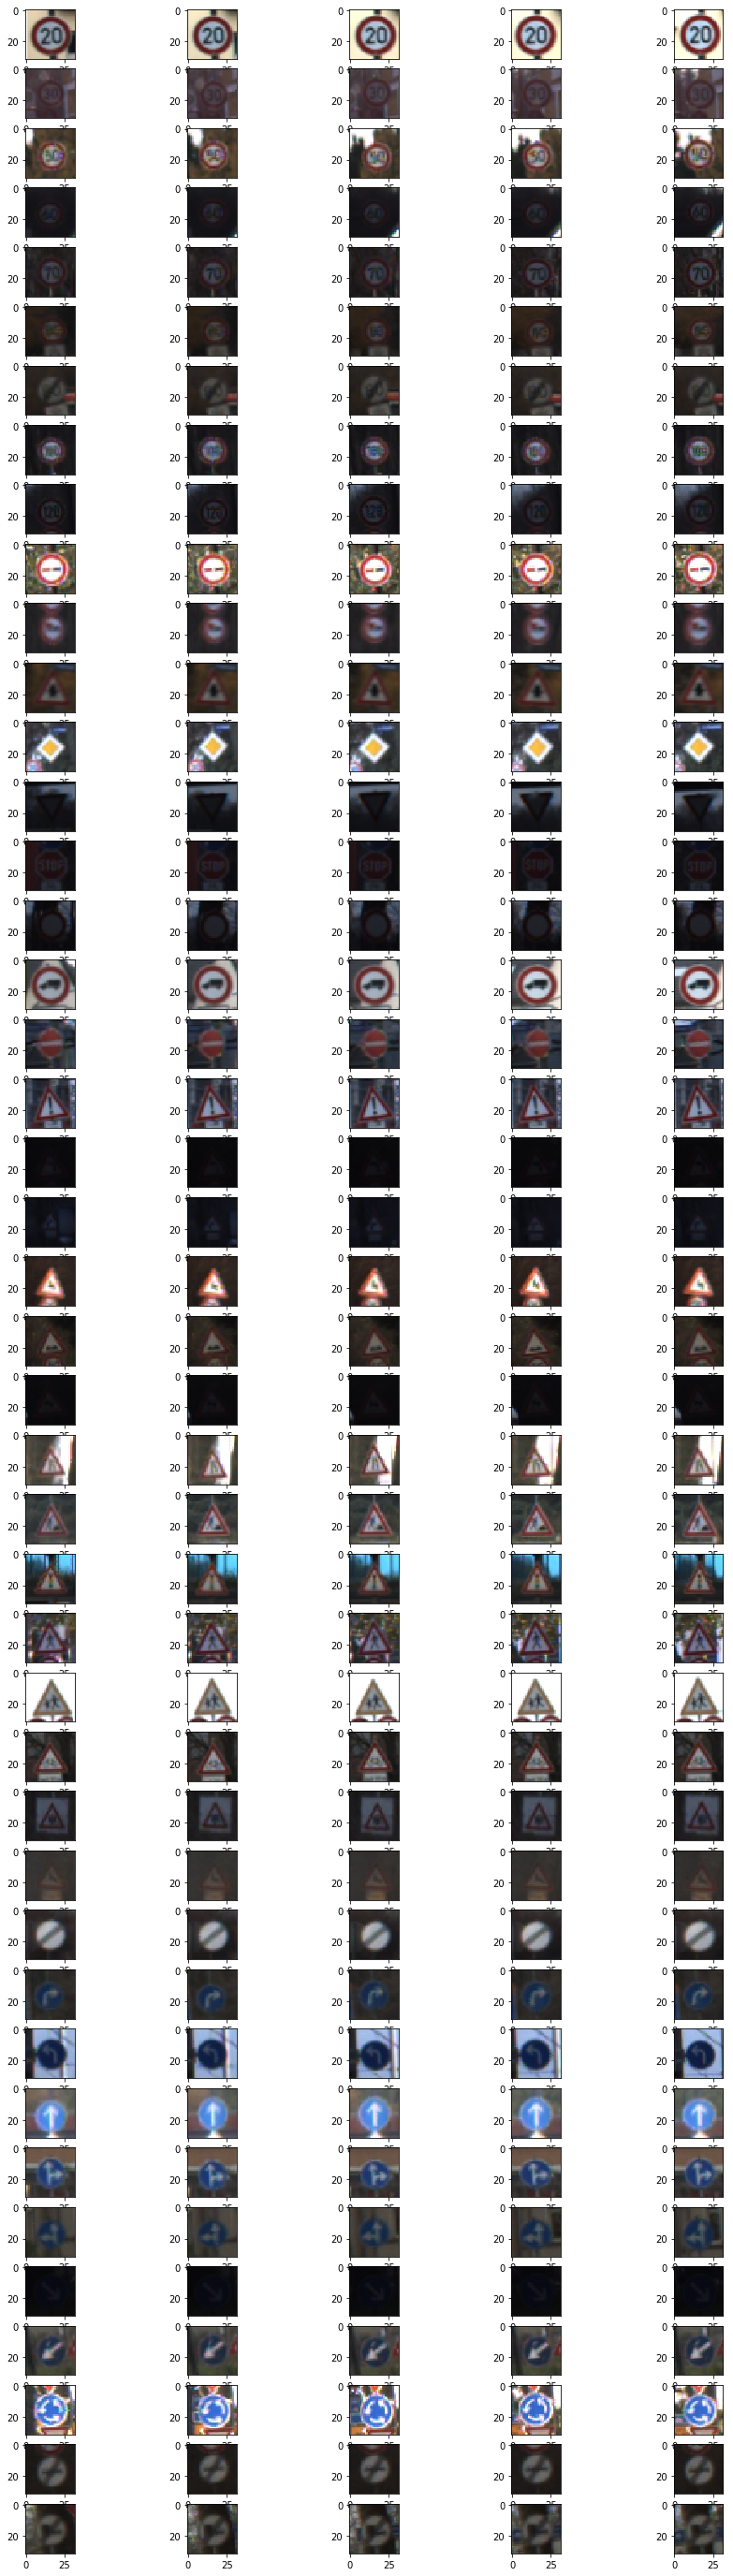

In [10]:
#shows 5 samples for each label
show_sample_for_each_label(X_train, y_train)

We can see that some of the pictures are very dark. They can have big differences in brightness.
If we inspect the picutres of each label we can see thata lot of picutres are just the same traffic sign. There is just a little transformation. That's a problem because our model can be confused by the background.

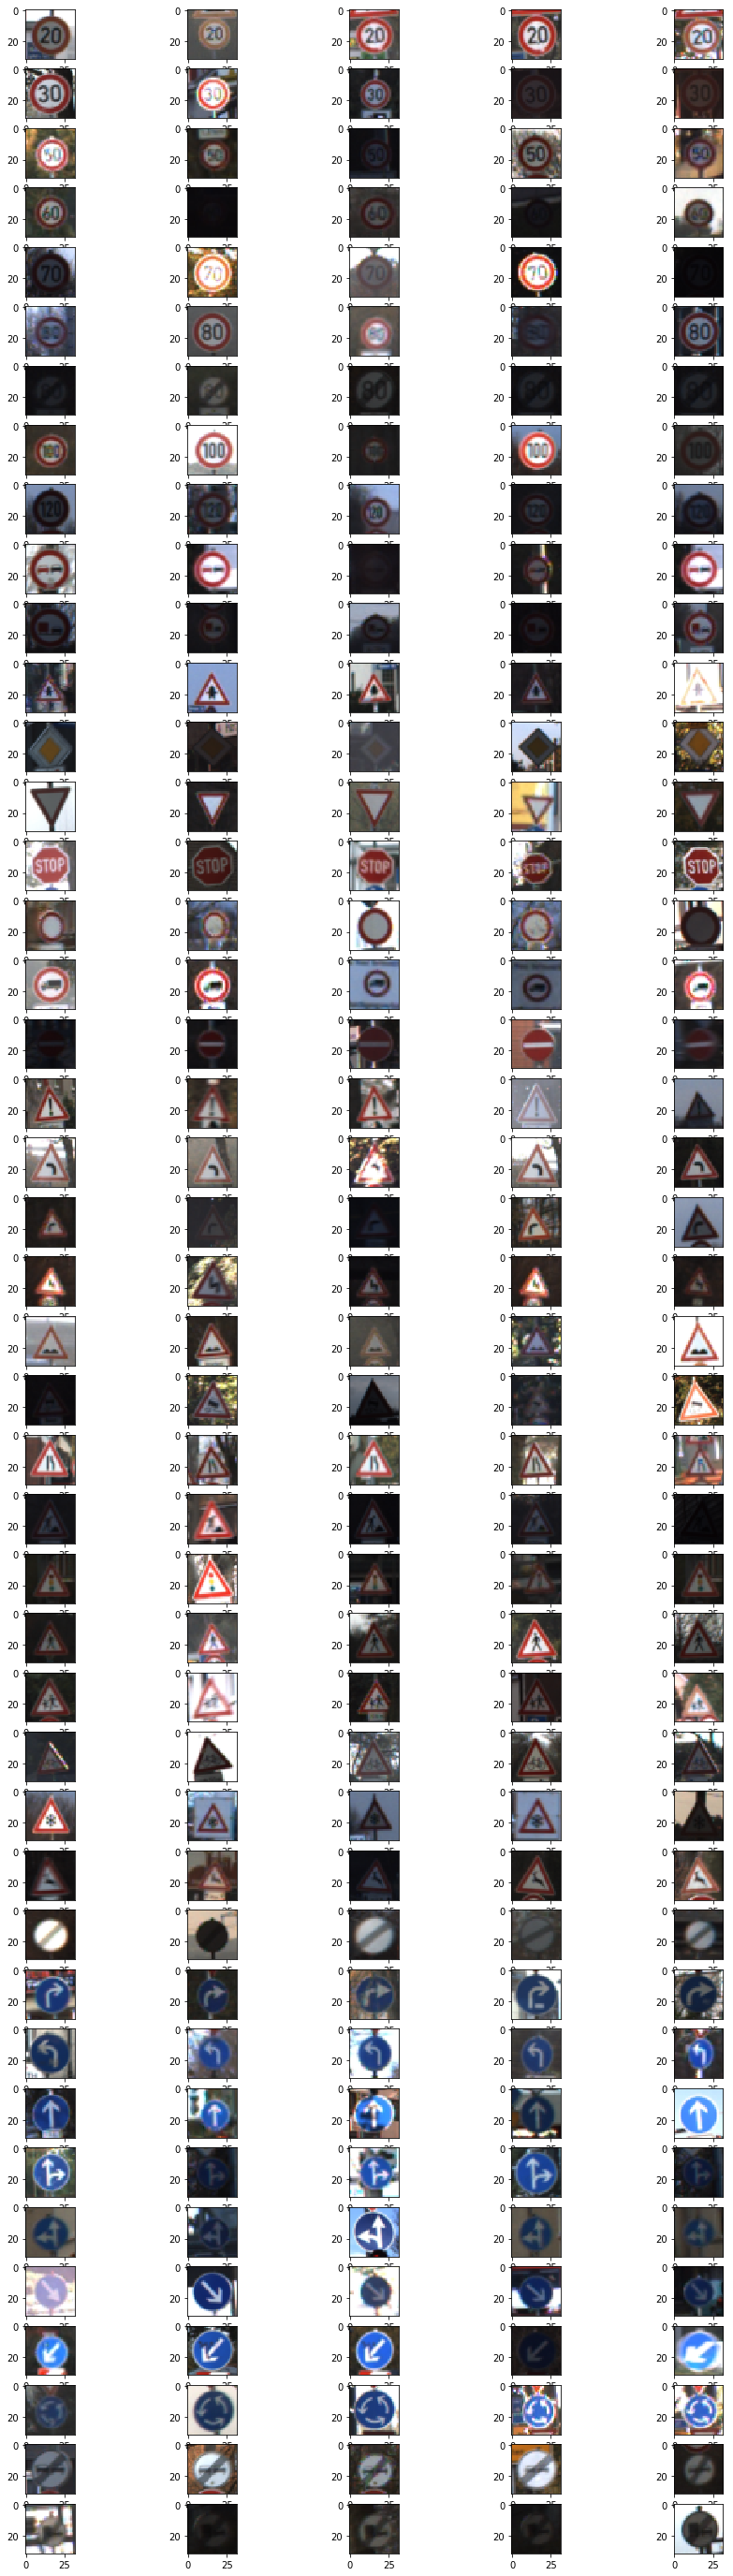

In [11]:
#shuffle the inputs for inspection
features, labels = shuffle(X_train, y_train)
show_sample_for_each_label(features, labels)

If we suffle the inputs we see more variety.

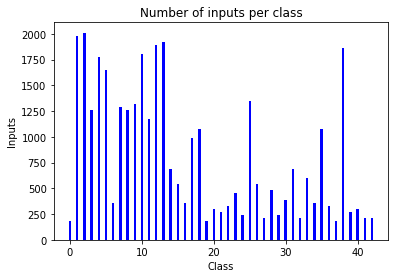

In [12]:
# show a bar plot with inputs per label
def show_inputs_per_label():
    inputs_per_class = np.bincount(y_train)
    max_inputs = np.max(inputs_per_class)

    mpl_fig = plt.figure()
    ax = mpl_fig.add_subplot(111)
    ax.set_ylabel('Inputs')
    ax.set_xlabel('Class')
    ax.set_title('Number of inputs per class')
    ax.bar(range(len(inputs_per_class)), inputs_per_class, 1/3, color='blue', label='Inputs per class')
    plt.show()

show_inputs_per_label()

Label 0 has under 250 inputs. Label 2 has a bit more that 2000. There is x10 difference of number of inputs between labels.

# Augment training data

To improve the performance of our model we can add more inputs just transforming the images with rotations, shear and translations. We can change the brightness to. I don't apply the change of brightness because I normalize the brightness of the pictures later.

In [13]:

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if False and brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

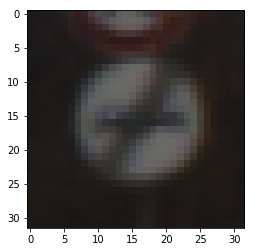

In [14]:
image = X_train[2]
plt.imshow(image)

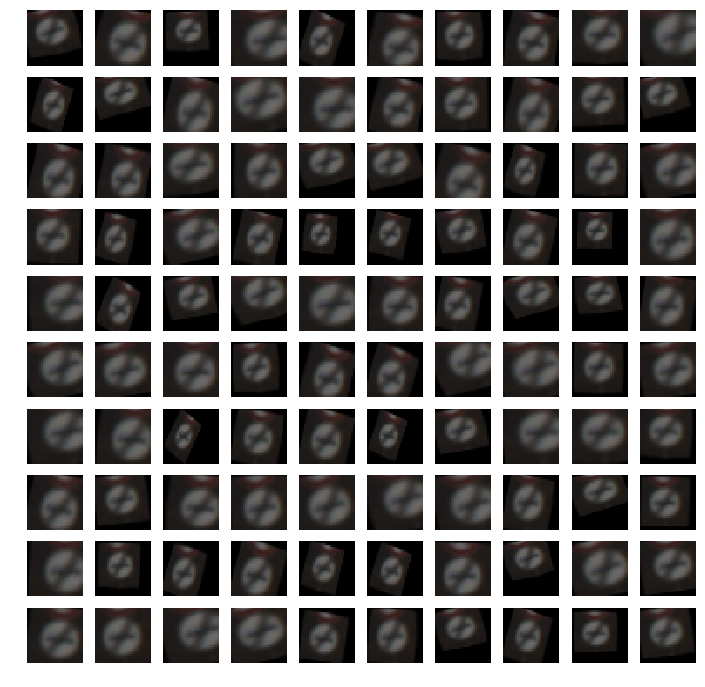

In [15]:
def show_examples_of_image_transformations():
    gs1 = gridspec.GridSpec(10, 10)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes.
    plt.figure(figsize=(12,12))
    for i in range(100):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        img = transform_image(image,20,10,5,brightness=0)

        plt.subplot(10,10,i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()
    
#we show many examples of image transformation
show_examples_of_image_transformations()

In [16]:
#code to augment input data with transformed images

def augment_data(features, labels, n=min_n_per_label):
    for label in range(n_classes):
        print("Augmenting data for {}".format(label))
        n_label = n - (labels==label).sum()
        indexes = np.where(labels==label)
        i=0
        while n_label>0:
            index = indexes[0][i]
            i+=1
            if i>len(indexes):i=0
            new_image = transform_image(features[index],20,10,5,brightness=1)
            new_image = np.array(new_image)
            shape = list(features.shape)
            features = np.append(features, new_image)
            shape[0]+=1
            features = features.reshape(shape)
            labels = np.append(labels, np.array([label]))
            n_label -= 1
    return features, labels

def load_augmented_data(reload=False,n=2000):
    file = 'data/train_augmented.p'
    if not os.path.exists(file) or reload:
        features, labels = augment_data(X_train, y_train,n)
        data = dict(features=features, labels=labels)
        with open(file, mode='wb') as f:
            pickle.dump(data, f)
    with open(file, mode='rb') as f:
           data = pickle.load(f)
    return data['features'], data['labels']  

In [17]:
#we augment the inputs with augmentation. The data is cached in a pickle file
X_train, y_train = load_augmented_data(n=2000)
show_inputs_per_label()

## One hot encoding

To train or model and make predictions we have to transform our labels from 0 to 42 to a one hot encoding format

In [18]:
def one_hot_encode(labels):
    from sklearn.preprocessing import LabelBinarizer
    label_binarizer = LabelBinarizer()
    return label_binarizer.fit_transform(labels)

y_train_one_hot = one_hot_encode(y_train)
y_valid_one_hot = one_hot_encode(y_valid)
y_test_one_hot  = one_hot_encode(y_test)

print("y_train_one_hot[0]:\n", y_train_one_hot[0], "\nindex:",y_train[0])

y_train_one_hot[0]:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0] 
index: 41


In [19]:
y_train_one_hot = one_hot_encode(y_train)
y_valid_one_hot = one_hot_encode(y_valid)
y_test_one_hot  = one_hot_encode(y_test)

## Normalize brightness in pictures

We normalize the brightness in the pictures so the model can be trained easily.

In [20]:
def normalize(f):
    lmin = float(f.min())
    lmax = float(f.max())
    return np.floor((f-lmin)/(lmax-lmin)*255.)

def normalize_set(images):
    for i in range(len(images)):
        images[i] = normalize(images[i])
    
#we normalize all sets: train, valid and test
for s in [X_train, X_valid, X_test]:
    normalize_set(s)

# Model arquitecture

In this part we create our model for German Traffic Sign Classification.

In [21]:
#helper fuctions to create our model.

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights, biases

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features



def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer, weights, biases

In [22]:
# We know that GTS images are 32 pixels in each dimension.
img_size = 32

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Number of classes, one class for each of 10 digits.
num_classes = 43


# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 64         # There are 36 of these filters.

filter_size3 = 5          # Convolution filters are 5 x 5 pixels.
num_filters3 = 128         # There are 36 of these filters.

# Fully-connected layer.
fc_size1 = 1024            # Number of neurons in fully-connected layer.
fc_size2 = 128            # Number of neurons in fully-connected layer.

dropout = 0.5             # dropout keep probability for the fc layer
dropout_conv = 0.7        # dropout keep probability for conv layer

In [41]:
#We create our model here

x = tf.placeholder(tf.float32, shape=[None, 32,32,3], name='x')
x_norm = (x/255.)-0.5 #input data normalized

y_true = tf.placeholder(tf.float32, shape=[None, 43], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1) #label result from input label

#keep_prob and keep_prob_conv are not constant. They have value of 1. when predicting
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
keep_prob_conv= tf.placeholder(tf.float32)

# layer_conv0, weights_conv0, biases_conv0 = \
# new_conv_layer(input=x_norm,
#                num_input_channels=num_channels,
#                filter_size=1,
#                num_filters=num_channels,
#                use_pooling=False)

layer_conv1, weights_conv1, biases_conv1 = \
    new_conv_layer(input=x_norm,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv2, weights_conv2, biases_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv3, weights_conv3, biases_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size2,
                   num_filters=num_filters3,
                   use_pooling=True)
    
drop_conv = tf.nn.dropout(layer_conv3, keep_prob_conv)

layer_conv1_1, weights_conv1_1, biases_conv1_1 = \
    new_conv_layer(input=drop_conv,
                   num_input_channels=num_filters3,
                   filter_size=3,
                   num_filters=num_filters1,
                   use_pooling=True)
layer_conv2_1, weights_conv2_1, biases_conv2_1 = \
    new_conv_layer(input=layer_conv1_1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

layer_conv3_1, weights_conv3_1, biases_conv3_1 = \
    new_conv_layer(input=layer_conv2_1,
                   num_input_channels=num_filters2,
                   filter_size=filter_size2,
                   num_filters=num_filters3,
                   use_pooling=True)    

drop_conv1 = tf.nn.dropout(layer_conv3_1, keep_prob_conv)

layer_flat, num_features = flatten_layer(drop_conv1)


layer_fc1,weights_fc1, biases_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size1,
                         use_relu=True)

layer_fc1_1,weights_fc1_1, biases_fc1_1 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size1,
                         num_outputs=fc_size2,
                         use_relu=True)

drop1 = tf.nn.dropout(layer_fc1_1, keep_prob)

layer_fc2,weights_fc2, biases_fc2 = new_fc_layer(input=drop1,
                         num_inputs=fc_size2,
                         num_outputs=num_classes,
                         use_relu=False)



y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

cost = tf.reduce_mean(cross_entropy)

# L2 regularization for the fully connected parameters.
# regularizers = tf.nn.l2_loss(weights_conv1) + tf.nn.l2_loss(biases_conv1) + \
#                tf.nn.l2_loss(weights_conv2) + tf.nn.l2_loss(biases_conv2) + \
#                tf.nn.l2_loss(weights_fc1) + tf.nn.l2_loss(biases_fc1) + \
#                tf.nn.l2_loss(weights_fc2) + tf.nn.l2_loss(biases_fc2)
# # Add the regularization term to the loss.
# beta = 5e-4  #0.0001
# cost += beta * regularizers

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)


correct_prediction = tf.equal(y_pred_cls, y_true_cls)

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 64

# Counter for total number of iterations performed so far.
total_iterations = 0

After many testing of different configurations for better prediction I opted for:

  Layer         | Notes
  ------------- | -------------
  5x5x32        | convolution
  5x5x64        | convolution
  5x5x128       | convolution
  dropout       | 0.7 keep probability
  3x3x32        | convolution
  3x3x64        | convolution
  3x3x128       | convolution
  dropout       | 0.7 keep probability
  flatten       | the image is flatten to an array
  fc 1024       | full connected layer of size 1024
  fc 128        | full connected layer of size 128
  output        | size 43, softmax
  
I use the AdamOptimizer. It has an adapting learning rate and good convergence speed. 
The convolution layer use 2x2 max pooling. 
The full connected layers use ReLu instead of sigmoid. It has better convergence properties. 

In [42]:
#ffunction to train our model. It runs the optimizer in session.
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations
    global X_train, y_train_one_hot

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for iteration in range(total_iterations,
                   total_iterations + num_iterations):
    	print("Epoch {}".format(iteration))
    	i=0
    	X_train, y_train_one_hot = shuffle(X_train, y_train_one_hot)
    	while i < len(X_train):
    		x_batch = X_train[i:i+train_batch_size]
    		y_true_batch = y_train_one_hot[i:i+train_batch_size]
    		i += train_batch_size
    		feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob: dropout, keep_prob_conv: dropout_conv}
    		session.run(optimizer, feed_dict=feed_dict)

    	acc = session.run(accuracy, feed_dict=feed_dict)
    	msg = "Training Accuracy: {}"
    	print(msg.format(acc))


    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


In [110]:
#shows the testing results
def print_test_accuracy(test_set = False, test_batch_size=256, show_example_errors=False, show_confusion_matrix=False):
    global X_valid, y_valid_one_hot, y_valid, X_test, y_test_one_hot, y_test
    if test_set:
        features, labels, y, data_set = X_test, y_test_one_hot, y_test, 'test'
    else:
        features, labels, y,data_set = X_valid, y_valid_one_hot, y_valid, 'valid'
    features, labels = shuffle(features, labels)
    i=0
    n=len(features)
    accuracies = []
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=n, dtype=np.int)
    cls_true = np.argmax(labels,axis=1)
    
    while i < len(features):
        j = min(i + test_batch_size, n)
        x_batch = features[i:j,:]
        y_true_batch = labels[i:j,:]
        feed_dict = {x: x_batch, y_true: y_true_batch, keep_prob: 1., keep_prob_conv:1.}
        acc = session.run(accuracy, feed_dict=feed_dict)
        accuracies.append(acc)
        y_pred_cls_r = session.run(y_pred_cls, feed_dict=feed_dict)

        cls_pred[i:j] = y_pred_cls_r
        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
    total_acc = 1.*sum(accuracies)/len(accuracies)
    msg = "Accuracy on {} set:{}"
    print(msg.format(data_set, total_acc))
    
    print("cls_true",cls_true)
    print("cls_pred", cls_pred)
   
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(features,labels,cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(features,labels,cls_pred=cls_pred)

In [45]:
#train our model for a number of epochs. If reload==False it will load the model from cache.
def train_or_restore(epochs=50, reload=False):
    file = 'model-gtf-1'
    saver = tf.train.Saver()
    if os.path.exists(file + ".meta") and not reload:
        print("Restored model from file")
        new_saver = tf.train.import_meta_graph(file + '.meta')
        new_saver.restore(session, tf.train.latest_checkpoint('./'))
    else:
        print("Training model for {} epochs".format(epochs))
        for i in range(epochs):
            optimize(num_iterations=1)
            print_test_accuracy()
        saver.save(session, file)
        print("Model stored in file")
    print_test_accuracy()
    
train_or_restore(epochs=100, reload=False)


Training model for 100 epochs
Epoch 20
Training Accuracy: 0.957446813583374
Time usage: 0:00:15
Accuracy on valid set:0.9316034852594569
Epoch 21
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9268453483996184
Epoch 22
Training Accuracy: 0.957446813583374
Time usage: 0:00:15
Accuracy on valid set:0.9273811164109603
Epoch 23
Training Accuracy: 0.914893627166748
Time usage: 0:00:15
Accuracy on valid set:0.9402426032052524
Epoch 24
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9327295483022496
Epoch 25
Training Accuracy: 0.978723406791687
Time usage: 0:00:15
Accuracy on valid set:0.9405240261036417
Epoch 26
Training Accuracy: 0.978723406791687
Time usage: 0:00:15
Accuracy on valid set:0.946265345034392
Epoch 27
Training Accuracy: 0.978723406791687
Time usage: 0:00:15
Accuracy on valid set:0.9351548612981603
Epoch 28
Training Accuracy: 0.936170220375061
Time usage: 0:00:15
Accuracy on valid set:0.9297899007797241
Epoch 29
Training Accuracy: 1.0
Time

Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9644379969956218
Epoch 105
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9691027420154517
Epoch 106
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9661518274873927
Epoch 107
Training Accuracy: 0.978723406791687
Time usage: 0:00:15
Accuracy on valid set:0.9574404583461043
Epoch 108
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9661844165428825
Epoch 109
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9657524107159048
Epoch 110
Training Accuracy: 0.957446813583374
Time usage: 0:00:15
Accuracy on valid set:0.9562332578327345
Epoch 111
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9578026965044547
Epoch 112
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9673442952874778
Epoch 113
Training Accuracy: 1.0
Time usage: 0:00:15
Accuracy on valid set:0.9640974143277043
Epoch 114
Training Accuracy: 1.0
Time usag

# Inspecting model

We inspect the model visualy.

In [82]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [83]:
def plot_example_errors(X,y,cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [84]:
def plot_confusion_matrix(X,y,cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Accuracy on valid set:0.9643199212021298
cls_true [20  8 14 ...,  4  5 27]
cls_pred [20  8 14 ...,  4  5 27]
Example errors:


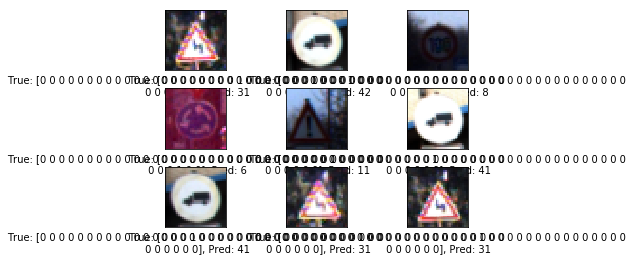

Confusion Matrix:


ValueError: Can't handle mix of multilabel-indicator and multiclass

In [111]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

# Visualize layers

In [112]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Now plot the filter-weights for the first convolutional layer.
Note that positive weights are red and negative weights are blue.

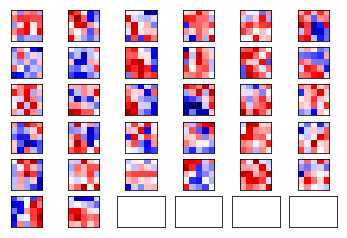

In [113]:
plot_conv_weights(weights=weights_conv1)

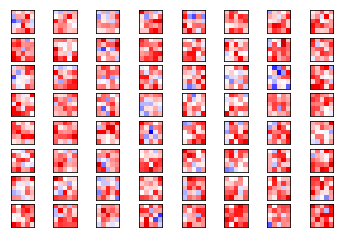

In [114]:
plot_conv_weights(weights=weights_conv2)

In [115]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

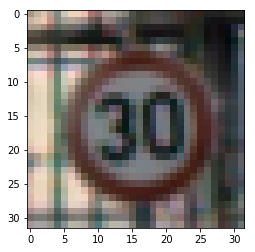

In [116]:
def plot_image(image):
    plt.imshow(image)

    plt.show()
    
plot_image(X_train[0])

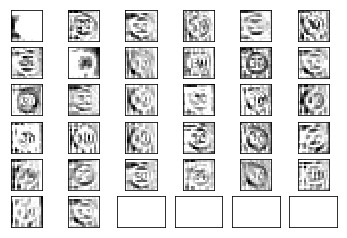

In [117]:
plot_conv_layer(layer=layer_conv1, image=X_train[0])

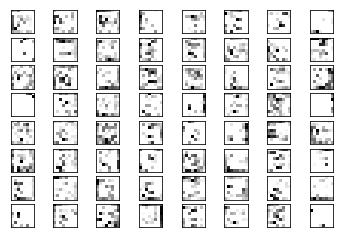

In [118]:
plot_conv_layer(layer=layer_conv2, image=X_train[0])

In [119]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=session,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

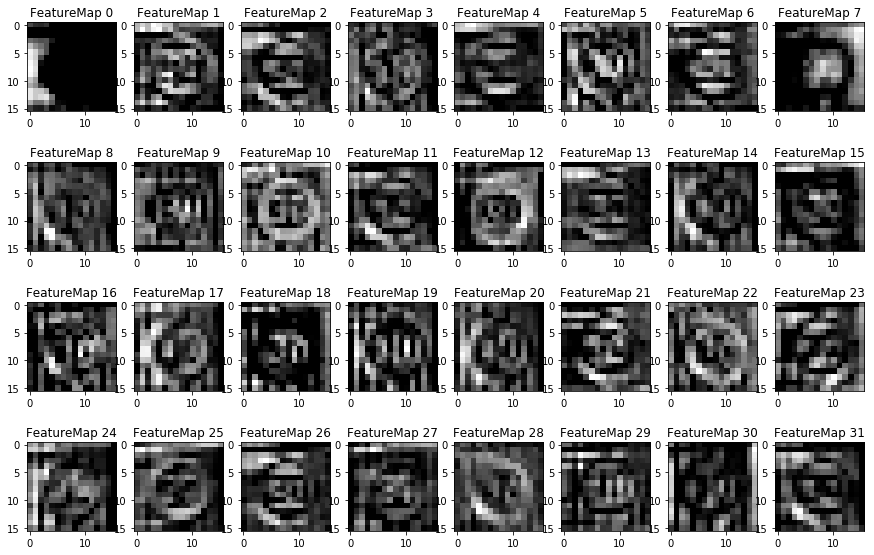

In [120]:
outputFeatureMap(X_train[0:100], layer_conv1, plt_num=20)

# Solution approach

I started with LeNet arquitecture for MNIST dataset, adapted for 32x32x3 images. It gives a good result but not good enough. I tried many arquitecures by hand. The most important improvement comes to add two dropout layers (one form convolution and the other for fc layers).

In [121]:
# Test model on new images

# Get new images

From internet I got 5 images to test them against the model.

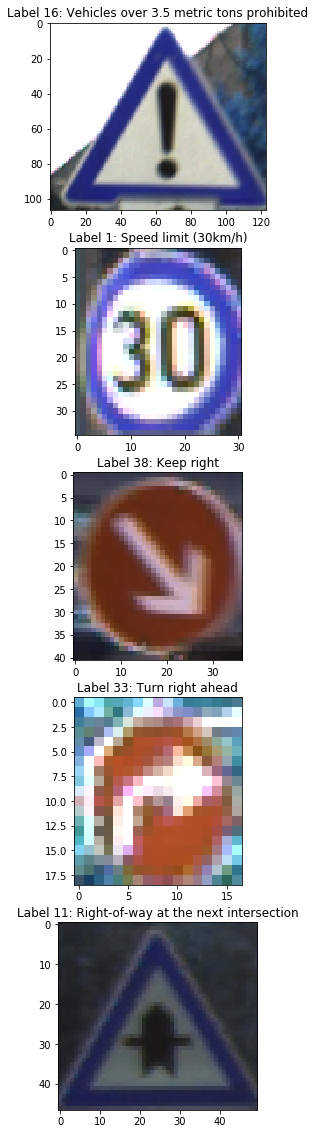

In [25]:
im1 = cv2.imread("images/00000.png")
im2 = cv2.imread("images/00001.png")
im3 = cv2.imread("images/00002.png")
im4 = cv2.imread("images/00003.png")
im5 = cv2.imread("images/00004.png")

images = [im1, im2, im3, im4, im5]
y_images=[16,1,38,33,11]

#resizing the images to 32x32x3
#for i,image in enumerate(images):
#    images[i] = cv2.resize(image, (32,32))
    
def show_extra_images():
    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,20))
    for i,image, label in zip(range(0,5),images, y_images):
        label_title = label_dict[label]
        axes.flat[i].set_title("Label {}: {}".format(label, label_title))
        axes.flat[i].imshow(image)
show_extra_images()

In [ ]:
# Performance on new images

In [ ]:
# Model Certainty - Softmax Probabilities

In [ ]:
def plot_preds(image, preds):
    """Displays image and the top-n predicted probabilities 
        in a bar graph  
    Args:    
        image: PIL image
        preds: list of predicted labels and their probabilities  
      """  
    #image
    plt.imshow(image)
    plt.axis('off')
  
    #bar graph
    plt.figure()  
    order = list(reversed(range(len(preds))))  
    bar_preds = [pr[2] for pr in preds]
    labels = (pr[1] for pr in preds)
    plt.barh(order, bar_preds, alpha=0.5)
    plt.yticks(order, labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1.01)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_example_preds(X,y,cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y[incorrect]
    
    # Plot the first 9 images.
    plot_preds(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [ ]:
# Precision and recall of each label